### Trying to simulate circuits with non-linear charactersitics in the time domain

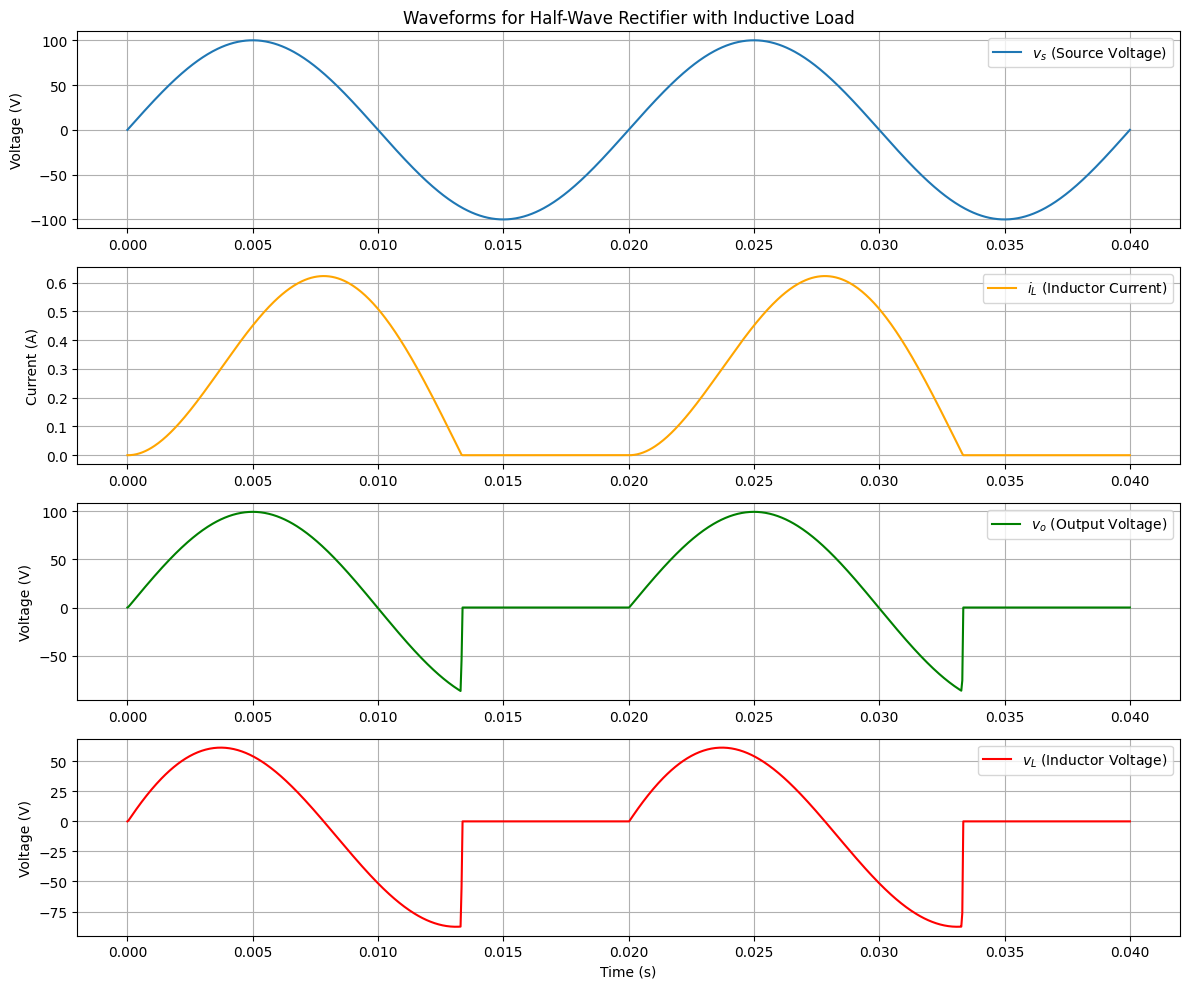

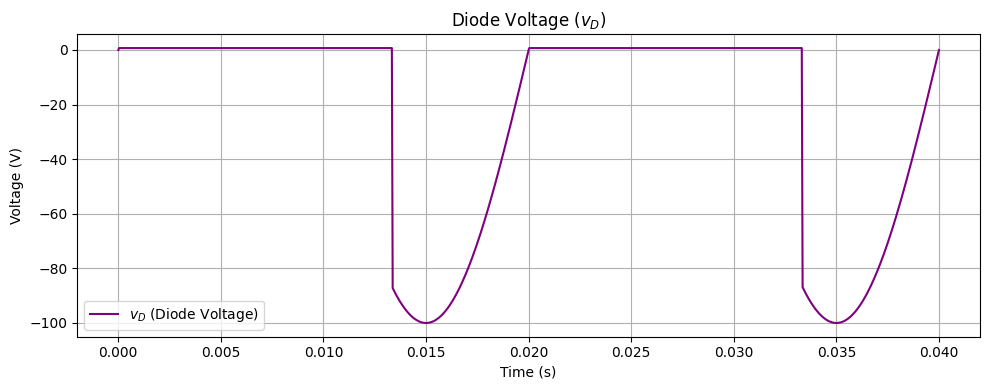

In [4]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# --- 1. Circuit Parameters ---
R_L = 100    # Ohms (Load Resistance)
L = 0.5     # Henrys (Inductance)

# AC Source Parameters
Vm = 100    # Peak voltage (Volts)
f = 50      # Frequency (Hz)
omega = 2 * np.pi * f # Angular frequency

# Diode Parameters (simple forward voltage drop model)
V_Don = 0.7 # Forward voltage drop of the diode (Volts)

# --- 2. Define the ODE Function ---
def rld_rectifier_ode(i_L, t, R_L, L, Vm, omega, V_Don):
    """
    Defines the differential equation for the half-wave rectifier with inductive load.
    The diode's behavior is modeled:
    - If vs - V_Don > 0 AND i_L >= 0, diode is ON.
    - Otherwise, diode is OFF, and i_L is clamped to 0.
    """
    vs = Vm * np.sin(omega * t)

    # Determine diode state
    if vs > V_Don or i_L > 1e-6: # Diode conducts if vs is high enough OR if current is still flowing (due to inductor)
        # If diode is ON
        # KVL: vs = V_Don + vL + iL*RL
        # vL = vs - V_Don - iL*RL
        # d(iL)/dt = vL / L
        if i_L >= 0: # Only allow current to flow forward
             didt = (vs - V_Don - i_L * R_L) / L
        else: # If current tries to go negative, diode turns off
            didt = 0
            i_L = 0 # Clamp current to 0, will be handled by the post-processing
    else:
        # If diode is OFF (vs <= V_Don and current has decayed to 0)
        didt = 0 # No current change
        i_L = 0 # No current flows

    return didt

# --- 3. Define Time Span ---
# Simulate for a few cycles to see steady-state behavior
num_cycles = 2
T_period = 1 / f
t_end = num_cycles * T_period
num_points = 1000 # Number of time points

time = np.linspace(0, t_end, num_points)

# --- 4. Set Initial Conditions ---
i_L0 = 0.0  # Initial current in the inductor (Amps)

# --- 5. Solve the ODE (and apply diode clamping) ---
# We'll need a custom loop to handle the diode's non-linear behavior correctly,
# especially when the current tries to go negative.
# scipy.integrate.odeint doesn't directly support state-dependent constraints (like i_L >= 0).
# We will run odeint and then post-process to apply the clamping.

# A more robust approach for this type of circuit is to use an event-detection
# solver (like solve_ivp with events) or manually iterate.
# For simplicity and to match the plots, let's modify the ODE slightly to handle it,
# and then clamp the result.

# The ode function will try to make the current negative if vs goes low enough.
# We'll take the output and manually set negative current to zero.

# The 'args' tuple must match the parameters after i_L, t in rld_rectifier_ode
current_solution = odeint(rld_rectifier_ode, i_L0, time, args=(R_L, L, Vm, omega, V_Don))
i_L_raw = current_solution.flatten()

# Post-process the current to enforce the diode's unidirectional flow
i_L = np.maximum(i_L_raw, 0) # Current cannot be negative due to the diode

# --- 6. Calculate Other Quantities ---
v_s = Vm * np.sin(omega * time)

# Output Voltage (vo) and Inductor Voltage (vL)
v_o = np.zeros_like(time)
v_L = np.zeros_like(time)
v_D = np.zeros_like(time)

for i in range(len(time)):
    if i_L[i] > 1e-6: # Diode is effectively ON if current is flowing
        v_o[i] = i_L[i] * R_L + L * np.gradient(i_L, time)[i]
        v_D[i] = V_Don # Diode voltage drop when ON
    else: # Diode is OFF (current is zero)
        v_o[i] = 0
        v_L[i] = 0
        # When diode is OFF and no current, v_D is approximately vs
        # (reverse biased, blocking the negative part of vs)
        v_D[i] = v_s[i] if v_s[i] < V_Don else V_Don # It blocks until it goes positive enough
        if v_D[i] > V_Don: # If vs would turn it on, but current is 0, it means it's just turning on.
            v_D[i] = V_Don # Clamp to forward voltage
        
    # Recalculate v_L from v_o and i_L*R_L to be consistent with the clamped i_L
    v_L[i] = v_o[i] - (i_L[i] * R_L)
    
    # Correction for v_o when diode is off:
    # If i_L is 0, then v_o = i_L * R_L = 0
    # The image shows v_o as 0 when i_L is 0.
    if i_L[i] == 0:
        v_o[i] = 0
        v_L[i] = 0 # If i_L is 0, d(i_L)/dt is also 0, so v_L is 0.
        # However, v_D will be negative (blocking reverse voltage)
        # v_s = v_D (approx) since v_o is 0

# Adjust v_D for when diode is OFF based on KVL and clamped i_L
# When i_L = 0, then v_o = 0. So, v_s = v_D
# If vs becomes positive but less than V_Don, v_D is vs.
# If vs is negative, v_D is vs.
for i in range(len(time)):
    if i_L[i] < 1e-6: # Diode is off (current is zero)
        v_D[i] = v_s[i] # v_s is dropped across the diode as it's blocking
        if v_D[i] > V_Don: # If vs goes positive, it tries to turn on
            v_D[i] = V_Don # But if i_L is still zero (e.g., just before turn-on), v_D is V_Don
    else: # Diode is on
        v_D[i] = V_Don # Constant V_Don when conducting


# --- 7. Plot Results ---
plt.figure(figsize=(12, 10))

# Plot vs
plt.subplot(4, 1, 1)
plt.plot(time, v_s, label='$v_s$ (Source Voltage)')
plt.title('Waveforms for Half-Wave Rectifier with Inductive Load')
plt.ylabel('Voltage (V)')
plt.grid(True)
plt.legend()

# Plot iL
plt.subplot(4, 1, 2)
plt.plot(time, i_L, label='$i_L$ (Inductor Current)', color='orange')
plt.ylabel('Current (A)')
plt.grid(True)
plt.legend()

# Plot vo
plt.subplot(4, 1, 3)
plt.plot(time, v_o, label='$v_o$ (Output Voltage)', color='green')
plt.ylabel('Voltage (V)')
plt.grid(True)
plt.legend()

# Plot vL
plt.subplot(4, 1, 4)
plt.plot(time, v_L, label='$v_L$ (Inductor Voltage)', color='red')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Additional plot for the diode voltage
plt.figure(figsize=(10, 4))
plt.plot(time, v_D, label='$v_D$ (Diode Voltage)', color='purple')
plt.title('Diode Voltage ($v_D$)')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
